In [1]:
require(readr)
library(reshape2)
library(ggmap)
stations <- read_tsv('../data/citibike_stations_2017.csv.zip')

Loading required package: readr
Loading required package: ggplot2
Parsed with column specification:
cols(
  dock_id = col_integer(),
  dock_name = col_character(),
  date = col_character(),
  hour = col_integer(),
  minute = col_integer(),
  pm = col_integer(),
  avail_bikes = col_integer(),
  avail_docks = col_integer(),
  tot_docks = col_integer(),
  `_lat` = col_double(),
  `_long` = col_double(),
  in_service = col_integer(),
  status_key = col_integer()
)


In [26]:
head(stations[stations$hour == 12,])

dock_id dock_name        date     hour minute pm avail_bikes avail_docks
1 72      W 52 St & 11 Ave 17-01-01 12    1     0  25          12         
2 72      W 52 St & 11 Ave 17-01-01 12    8     1  21          16         
3 72      W 52 St & 11 Ave 17-01-02 12   39     0  27          10         
4 72      W 52 St & 11 Ave 17-01-02 12   41     1  32           5         
5 72      W 52 St & 11 Ave 17-01-03 12   34     1  37           2         
6 72      W 52 St & 11 Ave 17-01-04 12   28     0  34           5         
  tot_docks _lat     _long     in_service status_key
1 39        40.76727 -73.99393 1          1         
2 39        40.76727 -73.99393 1          1         
3 39        40.76727 -73.99393 1          1         
4 39        40.76727 -73.99393 1          1         
5 39        40.76727 -73.99393 1          1         
6 39        40.76727 -73.99393 1          1

In [28]:
nrow(stations)

[1] 5350485

I'm interested in knowing how the availability of the bikes changes over the course of a day. To do this, I'll first compute the percentage of available bikes and transform the hour into 24-hour time.

In [29]:
stations['avail_bikes_percent'] = stations['avail_bikes'] / stations['tot_docks']
stations$hour[stations$pm == 1 & stations$hour != 12] <- stations$hour[stations$pm == 1 & stations$hour != 12] + 12 # Use 24 hour time
stations$hour[stations$pm == 0 & stations$hour == 12] <- stations$hour[stations$pm == 0 & stations$hour == 12] + 12 # Use 24 hour time
stations$avail_bikes_percent[is.na(stations$avail_bikes_percent)] <- 0
stations_subset <- subset(stations, select=c('dock_id', 'dock_name', "date", "hour", 'avail_bikes_percent'))

Next, I will transform the dataset into a wide format: adding 24 columns for each hour of the day.

In [30]:
avail_by_hour <- dcast(stations_subset, dock_id + dock_name + date ~ hour, mean, fill=0)

Using avail_bikes_percent as value column: use value.var to override.


In [31]:
head(avail_by_hour)

dock_id dock_name        date     1         2         3         4        
1 72      W 52 St & 11 Ave 17-01-01 0.6666667 0.6666667 0.6666667 0.6666667
2 72      W 52 St & 11 Ave 17-01-02 0.7179487 0.7435897 0.7435897 0.0000000
3 72      W 52 St & 11 Ave 17-01-03 0.9230769 0.9230769 0.9230769 0.9230769
4 72      W 52 St & 11 Ave 17-01-04 0.8717949 0.8717949 0.8717949 0.8461538
5 72      W 52 St & 11 Ave 17-01-05 0.3589744 0.3589744 0.3589744 0.3846154
6 72      W 52 St & 11 Ave 17-01-06 0.1794872 0.2307692 0.2307692 0.2307692
  5         6         7         ⋯ 15        16         17         18        
1 0.6666667 0.6153846 0.6153846 ⋯ 0.5384615 0.51282051 0.56410256 0.66666667
2 0.7179487 0.7179487 0.6923077 ⋯ 0.0000000 0.89743590 0.92307692 0.89743590
3 0.8974359 0.9487179 0.0000000 ⋯ 0.0000000 0.92307692 0.89743590 0.84615385
4 0.8205128 0.0000000 0.8461538 ⋯ 0.6666667 0.61538462 0.48717949 0.28205128
5 0.3846154 0.4615385 0.0000000 ⋯ 0.4102564 0.33333333 0.00000000 0.28205128
6 0.2307692 0.2564103 0.3076923 ⋯ 0.0000000 0.05128205 0.02564103 0.05128205
  19         20        21        22        23        24       
1 0.00000000 0.5897436 0.6410256 0.6923077 0.6923077 0.6410256
2 0.87179487 0.8461538 0.8461538 0.9230769 0.9230769 0.6923077
3 0.79487179 0.0000000 0.7435897 0.8205128 0.8461538 0.0000000
4 0.30769231 0.0000000 0.3589744 0.3333333 0.3333333 0.8717949
5 0.23076923 0.1025641 0.1794872 0.1538462 0.0000000 0.3589744
6 0.02564103 0.0000000 0.2051282 0.2051282 0.1794872 0.1794872

In [33]:
nrow(avail_by_hour)

[1] 191313

Next to reduce the size of the dataset, each station and average each hour together. Thereby producing the average hourly availability per station. 

In [34]:
library(ggplot2)
melted_by_hour <- melt(avail_by_hour, id.vars=c("dock_id", "dock_name", "date"))
avg_by_hour <- aggregate(melted_by_hour$value, list(melted_by_hour$dock_id, melted_by_hour$variable), mean, na.rm=TRUE)
head(avg_by_hour)

Group.1 Group.2 x        
1  72     1       0.2949163
2  79     1       0.1832912
3  82     1       0.3271605
4  83     1       0.3233647
5 116     1       0.1929309
6 119     1       0.4652517

In [35]:
nrow(avg_by_hour)

[1] 16992

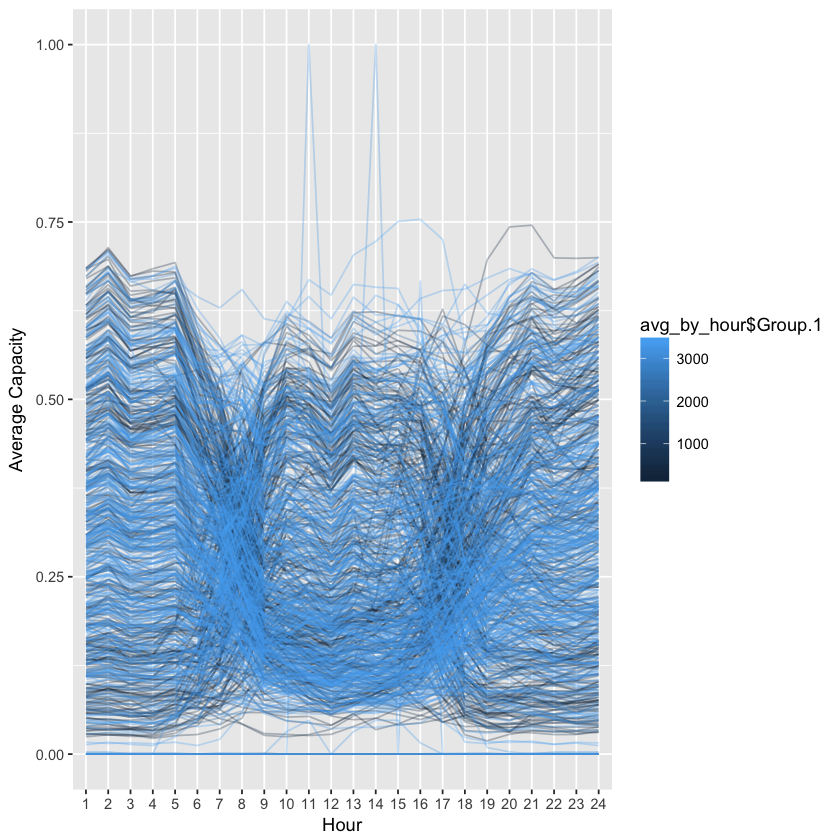

In [7]:
ggplot(avg_by_hour, aes(x=avg_by_hour$Group.2, y=avg_by_hour$x, group=avg_by_hour$Group.1, color=avg_by_hour$Group.1)) + 
    geom_line(alpha=0.3) + 
    xlab("Hour") + 
    ylab("Average Capacity")

To attempt to separate the data, I am utilizing a k-means clustering algorithm. After experimenting with the number of clusters, I found that 6 clusters produced the best separation (note that I will later merge these clusters into 3 clusters). 

Note that running the clustering may change which stations are assigned to each cluster, meaning the numbering may be different, but the contents of the clusters should be the same.

In [38]:
test <- avg_by_hour
test$x[is.na(test$x)] = 0
dtest <- dcast(test, Group.1 ~ Group.2)

clusters <- kmeans(subset(dtest, select=-c(Group.1)), 6, iter.max=20, algorithm='MacQueen')
summary(clusters)

out <- cbind(dtest, clusterNum = clusters$cluster)
first_cluster = melt(subset(out[out$clusterNum == 1,], select=-c(clusterNum)), id.vars='Group.1')
second_cluster = melt(subset(out[out$clusterNum == 2,], select=-c(clusterNum)), id.vars='Group.1')
third_cluster = melt(subset(out[out$clusterNum == 3,], select=-c(clusterNum)), id.vars='Group.1')
fourth_cluster = melt(subset(out[out$clusterNum == 4,], select=-c(clusterNum)), id.vars='Group.1')
fifth_cluster = melt(subset(out[out$clusterNum == 5,], select=-c(clusterNum)), id.vars='Group.1')
sixth_cluster = melt(subset(out[out$clusterNum == 6,], select=-c(clusterNum)), id.vars='Group.1')

Using x as value column: use value.var to override.


             Length Class  Mode   
cluster      708    -none- numeric
centers      144    -none- numeric
totss          1    -none- numeric
withinss       6    -none- numeric
tot.withinss   1    -none- numeric
betweenss      1    -none- numeric
size           6    -none- numeric
iter           1    -none- numeric
ifault         0    -none- NULL   

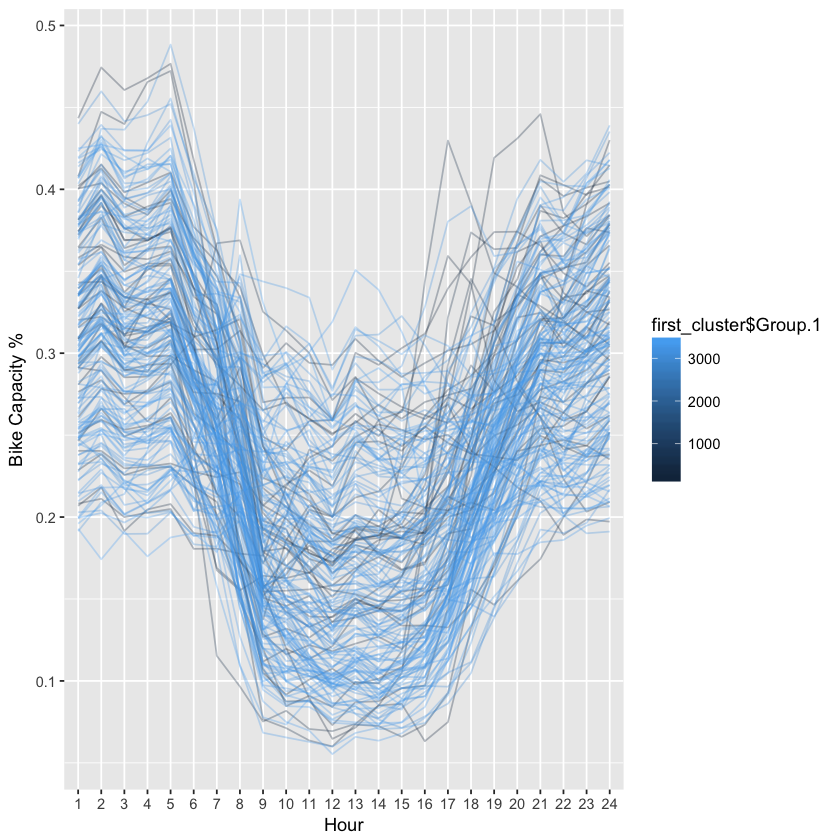

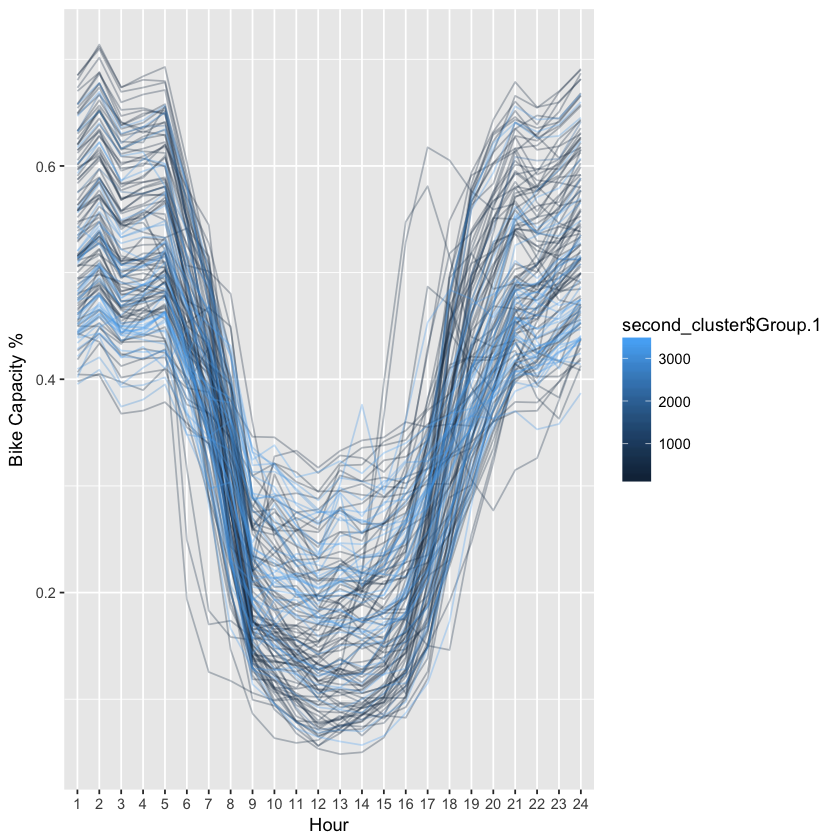

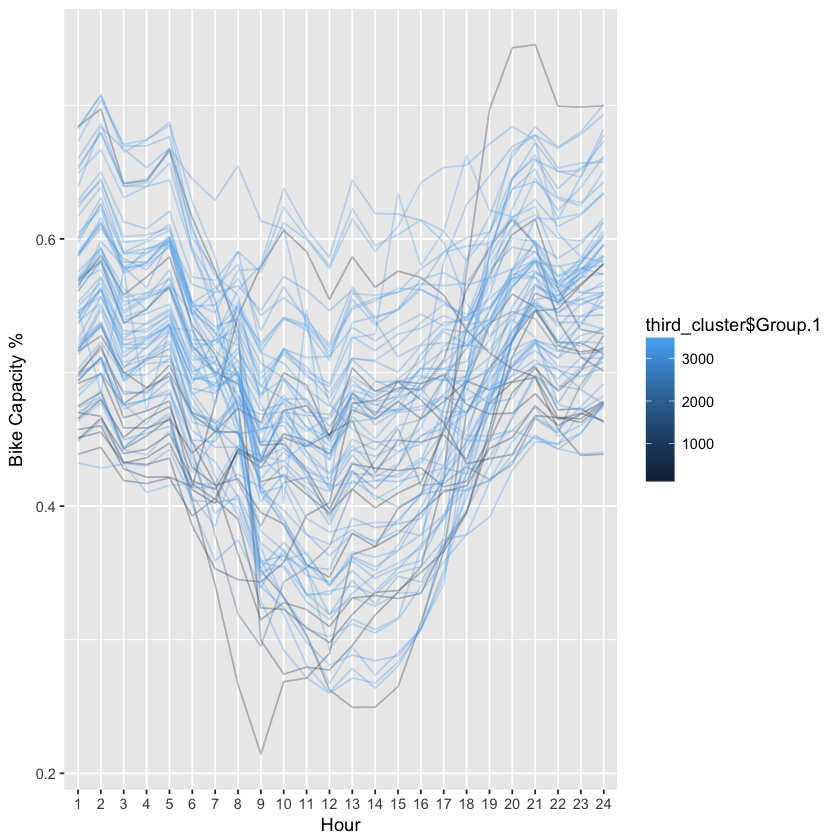

In [40]:
ggplot(first_cluster, aes(x=first_cluster$variable, y=first_cluster$value, group=first_cluster$Group.1, color=first_cluster$Group.1)) + 
    geom_line(alpha=0.3) + 
    xlab("Hour") + 
    ylab("Bike Capacity %")
ggplot(second_cluster, aes(x=second_cluster$variable, y=second_cluster$value, group=second_cluster$Group.1, color=second_cluster$Group.1)) + 
    geom_line(alpha=0.3) + 
    xlab("Hour") + 
    ylab("Bike Capacity %")
ggplot(third_cluster, aes(x=third_cluster$variable, y=third_cluster$value, group=third_cluster$Group.1, color=third_cluster$Group.1)) + 
    geom_line(alpha=0.3) + 
    xlab("Hour") + 
    ylab("Bike Capacity %")

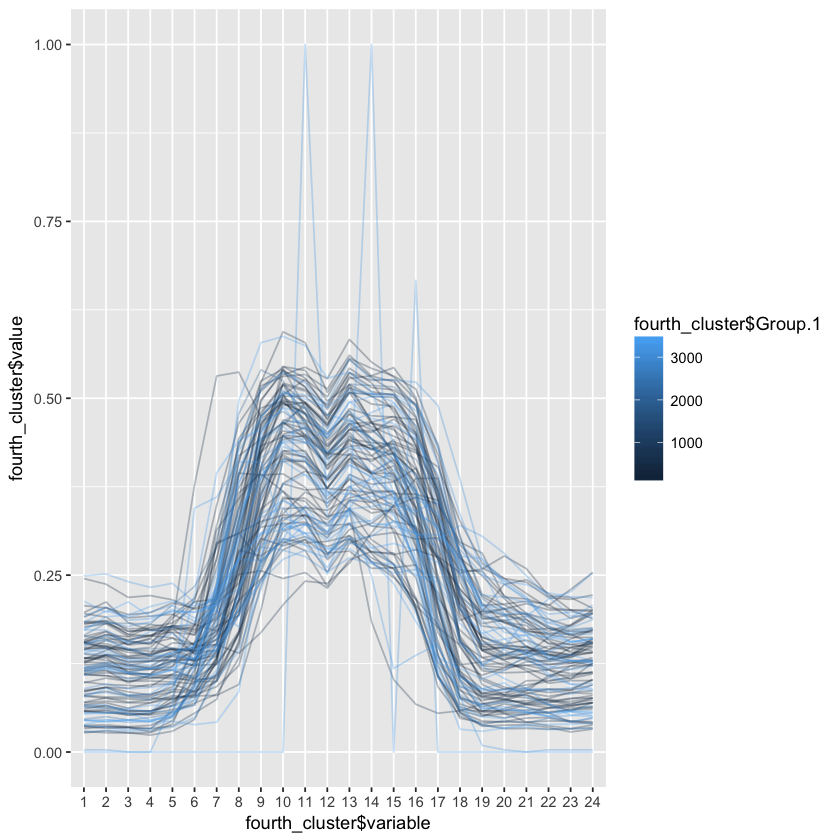

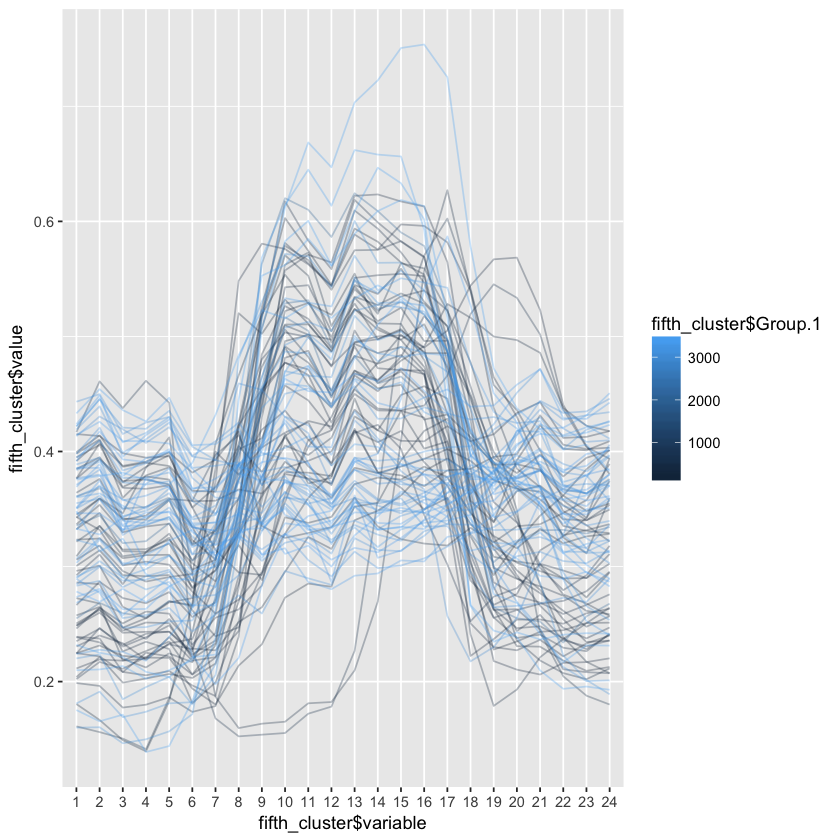

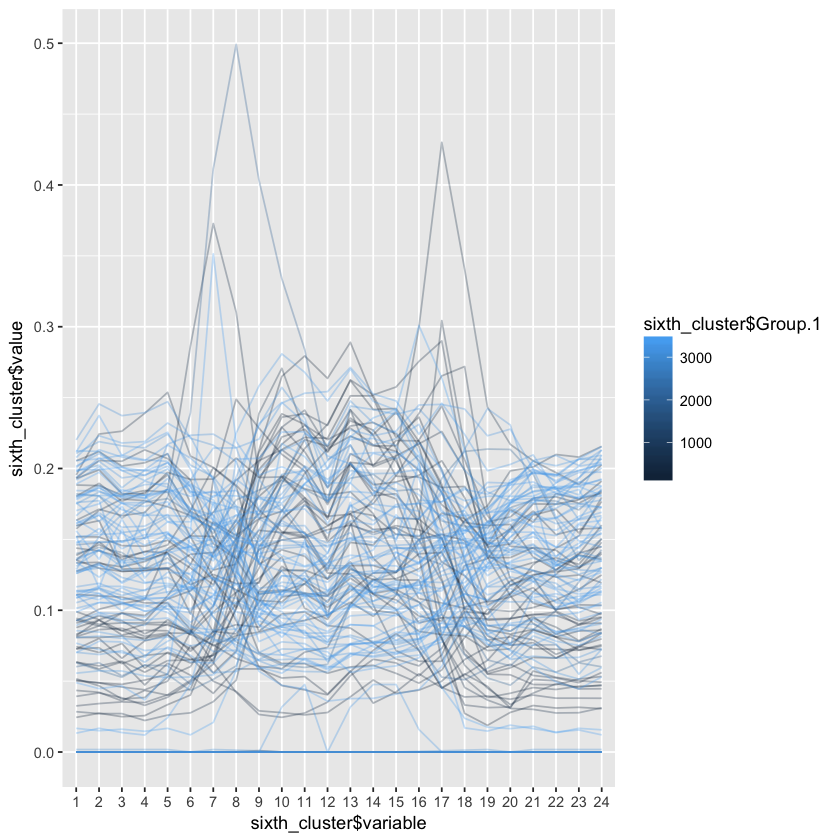

In [41]:
ggplot(fourth_cluster, aes(x=fourth_cluster$variable, y=fourth_cluster$value, group=fourth_cluster$Group.1, color=fourth_cluster$Group.1)) + 
    geom_line(alpha=0.3) 
ggplot(fifth_cluster, aes(x=fifth_cluster$variable, y=fifth_cluster$value, group=fifth_cluster$Group.1, color=fifth_cluster$Group.1)) + 
    geom_line(alpha=0.3) 
ggplot(sixth_cluster, aes(x=sixth_cluster$variable, y=sixth_cluster$value, group=sixth_cluster$Group.1, color=sixth_cluster$Group.1)) + 
    geom_line(alpha=0.3) 

In [42]:
cluster_one_stations <- unique(subset(stations[stations$dock_id %in% first_cluster$Group.1,], select=c("dock_id", "dock_name", "_lat", "_long", 'hour', 'avail_bikes_percent')))
cluster_two_stations <- unique(subset(stations[stations$dock_id %in% second_cluster$Group.1,], select=c("dock_id", "dock_name", "_lat", "_long", 'hour', 'avail_bikes_percent')))
cluster_three_stations <- unique(subset(stations[stations$dock_id %in% third_cluster$Group.1,], select=c("dock_id", "dock_name", "_lat", "_long", 'hour', 'avail_bikes_percent')))
cluster_four_stations <- unique(subset(stations[stations$dock_id %in% fourth_cluster$Group.1,], select=c("dock_id", "dock_name", "_lat", "_long", 'hour', 'avail_bikes_percent')))
cluster_five_stations <- unique(subset(stations[stations$dock_id %in% fifth_cluster$Group.1,], select=c("dock_id", "dock_name", "_lat", "_long", 'hour', 'avail_bikes_percent')))
cluster_six_stations <- unique(subset(stations[stations$dock_id %in% sixth_cluster$Group.1,], select=c("dock_id", "dock_name", "_lat", "_long", 'hour', 'avail_bikes_percent')))

From the graphs above: 
- It is clear that clusters one, two, and three have a large demand for bikes in the morning (around 8am) and the evening (around 6pm) experiences an increase supply of bikes. Meaning this would correlate with individuals commuting to work from their homes.
- Clusters four and five also exhibits a clear pattern of an increased supply of bikes arriving in the morning and an increased demand for bikes in the evening. Meaning that this cluster likely is located near work places, and these shifts in demand represent commuters arriving on their way to work.
- Clusters 6 experienced mostly constant demand. This is likely be an artifact of the averaging techniques used.


In [46]:
residential <- rbind(cluster_one_stations, cluster_two_stations, cluster_three_stations)
work <- rbind(cluster_four_stations, cluster_five_stations)
low <- rbind(cluster_six_stations)

Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=New%20York&sensor=false
Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=40.712775,-74.005973&zoom=12&size=640x640&scale=2&maptype=terrain&sensor=false


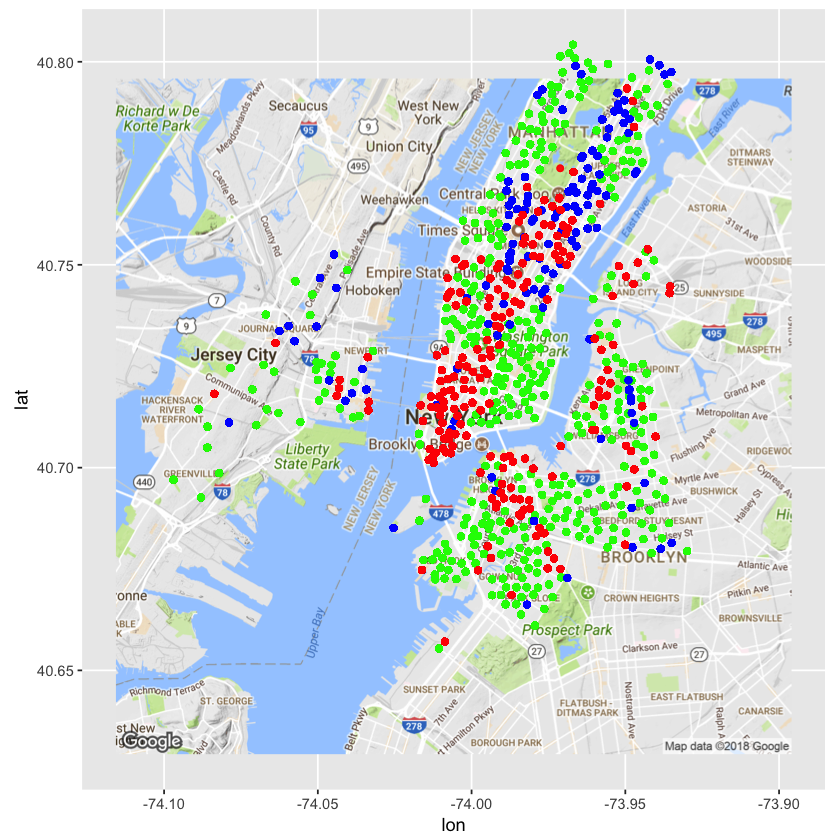

In [47]:
NYC_map = ggmap(get_googlemap(center=as.numeric(geocode("New York")), scale=2, zoom=12), extent="normal")
NYC_map + 
    geom_point(aes(x=residential["_long"], y=residential["_lat"]), data=residential, col="green", alpha=0.4) +
    geom_point(aes(x=low["_long"], y=low["_lat"]), data=low, alpha=0.4, col="blue") +
    geom_point(aes(x=work["_long"], y=work["_lat"]), data=work, alpha=0.4, col='red')  

Plotting these clusters on a map of New York City seems to confirm my hypothesis in terms of geographic location. The "work" cluster largely is located in the financial district, near where many people work. While the "residential" cluster is located where people live, in the East Village and Brooklyn.

In [48]:
write.csv(low, file='low_cluster.csv')
write.csv(residential, file='residential_cluster.csv')
write.csv(cluster_five_stations, file='work_cluster.csv')